In [2]:
from math import radians,sin,cos,asin,sqrt
import math
import time
import json
import random
import copy
import traceback
import pickle
import requests
import warnings
from scipy import spatial
import numpy as np
import networkx as nx
from functools import reduce
import geojson
from pandas.io.json import json_normalize
from coord_convert.transform import wgs2gcj, wgs2bd, gcj2wgs, gcj2bd, bd2wgs, bd2gcj
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from shapely.geometry import Polygon,Point
warnings.filterwarnings("ignore")

In [3]:
# 基础参数
city_id = 325
span_id = 41
laborId =  32746
worker_lon = 108.83657361153455
worker_lat = 23.22830741146853
traceId = 'test'
city_lon = 108.82846
city_lat = 23.229486

EARTH_RADIUS = 6371393.0
RADIUS_SCALE = math.pi / 180.

min_dispatch_num = 3 # 挪车下限
max_dispatch_num = 5 # 挪车上限，最大可运车辆数
station_radius = 25 # 车站半径
static_time_threshold = 86400 # 不动车时间阈值

greedy_lookahead_station_num = 2 # 选站时多2个车站，贪心的cvrp
expect_order_num = 5 # 期望的最大满载的车辆数
min_distance_to_station = 100 # 人车最短距离
nearest_bike_scaler = 2 # 扩增参数，多取点车

In [4]:
# 经纬度转平面坐标
def get_plan_coordinate(city_lon,city_lat,point_lon,point_lat):

    center_longitude = city_lon* RADIUS_SCALE
    center_latitude = city_lat* RADIUS_SCALE
    bike_x = point_lon * RADIUS_SCALE
    bike_y = point_lat * RADIUS_SCALE

    bike_current_lat_radius = EARTH_RADIUS * math.cos(bike_y)
    bike_x_dist = bike_current_lat_radius * (bike_x - center_longitude)
    bike_y_dist = EARTH_RADIUS * (bike_y - center_latitude)
    return bike_x_dist,bike_y_dist

# 距离公式
def haversine_dis(lon1, lat1, lon2, lat2):

    #将十进制转为弧度
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    #haversine公式
    d_lon = lon2 - lon1
    d_lat = lat2 - lat1
    aa = sin(d_lat/2)**2 + cos(lat1)*cos(lat2)*sin(d_lon/2)**2
    c = 2 * asin(sqrt(aa))
    return c*EARTH_RADIUS



#### 获取可派车站

In [5]:
def get_station():
    # 车站中心坐标
    with open('station_point.pkl','rb') as f:
        station_point = pickle.load(f)
    # 车站目标量、预估流入、24h预估收益
    with open('station_target.pkl','rb') as f:
        station_target = pickle.load(f)
    # 所有可用车
    with open('bike_list_origin.pkl','rb') as f:
        bike_list = pickle.load(f)

    # print("车站基础信息: %s,\n 车站中心坐标: %s"%(station_target[0],station_point))

    # 车站基础数据加工
    station_origin = []
    filter_station_list = [] # 白/黑名单车站
    for obj in station_target:
        if obj["station_id"] in filter_station_list: # 过滤名单车站
            continue
        if obj["station_id"] in station_point: # 添加有中心点的线上生效车站
            newobj = obj
            newobj['lon'] = float(station_point[obj["station_id"]]["lon"])
            newobj["lat"] = float(station_point[obj["station_id"]]["lat"])
            newobj["worker_dis"] = haversine_dis(newobj['lon'],newobj["lat"],worker_lon,worker_lat) # 距工人距离(m)
            station_origin.append(newobj)
    # station_origin[0]

    # 可根据实际业务过滤其他派单策略类型
    # 如过滤 堆积区车站
    # 堆积区逻辑：通过dbscan找到历史每天车辆堆积大于一定数量区域，存一个区域polygon标记易堆积区
    # 过滤堆积区逻辑：遍历易堆积区域，判断车站坐标是否在区域内 pile_area.contains(point)？

    # 过滤掉不满足最小派单车辆数的车站
    station_filter_min_num = []
    for obj in station_origin:
        #初步过滤不符合要求的车站，提升性能 target  - predict_in >= min_dispatch_num
        if obj["target_bike_cnt"] - obj["predict_in_bike_cnt"] >= min_dispatch_num :
            station_filter_min_num.append(obj)
    
    bike_tree = spatial.KDTree([ get_plan_coordinate(city_lon,city_lat, x['longitude'],x['latitude'])  for x in bike_list])
    #计算车站25米范围车的数量
    if len(station_filter_min_num) > 0: # 如果过滤完还有车站数据，计算车站周围25m内车辆数
        station_bikes = bike_tree.query_ball_point([get_plan_coordinate(city_lon,city_lat,x["lon"],x["lat"]) for x in station_filter_min_num],station_radius)
        for i in range(len(station_filter_min_num)):
            station_filter_min_num[i]["context_bike_num"] = len(station_bikes[i])
            station_filter_min_num[i]["context_bike_sns"] = [ bike_list[idx]["bikeSn"] for idx in station_bikes[i]]
            station_filter_min_num[i]["context_bikes"] = [ bike_list[idx] for idx in station_bikes[i]]
    # 考虑实时周围车辆数后，通过target_revise二次过滤车站
    final_stations = []
    for obj in station_filter_min_num:
        obj["target_revise"] = obj["target_bike_cnt"] - obj["predict_in_bike_cnt"] - obj["context_bike_num"]
        if obj["target_revise"] >= min_dispatch_num:
            final_stations.append(obj)
    len(final_stations)
    return final_stations
len(get_station())

14

#### 获取可派不动车

In [6]:
def get_static_bike():
     # 所有可用车
    with open('bike_list_origin.pkl','rb') as f:
        bike_list = pickle.load(f)
    print('可用车数量：',len(bike_list))
    # 获取不动车,此处为>24h不动
    static_bike_list = []
    for b in bike_list:
        if b["static_hours"] > static_time_threshold/3600:
            static_bike_list.append(b)
    print('不动车数量：',len(static_bike_list))
    # 过滤掉已经在车站中的不动车
    station_bikes_set = set()
    final_stations = get_station()
    for s in final_stations:
        if "context_bike_sns" in s:
            for sn in s["context_bike_sns"]:
                station_bikes_set.add(sn) 
    #print("station_bikes_set",len(station_bikes_set),station_bikes_set)
    filted_bike_list = []
    for b in static_bike_list:
        if b["bikeSn"] not in station_bikes_set:
            filted_bike_list.append(b)
    print('不在车站内的不动车数量：',len(filted_bike_list))
    return filted_bike_list
get_static_bike()[0]


可用车数量： 2417
不动车数量： 650
不在车站内的不动车数量： 649


{'bikeSn': '819211916',
 'longitude': 108.844097,
 'latitude': 23.227359,
 'blockId': '8b4152702a4efff',
 'attributeList': [{'key': 4, 'value': 18}],
 'lastOrderEndTime': 1671786662000,
 'lastMoveEndTime': 1671673025000,
 'static_hours': 431.474686538842,
 'to_labor_distance': 776.0017030812481}

#### 可派不动车组团

In [7]:
def get_bike_clusters():

    # 超x天不动车辆
    # with open('bike_list.pkl','rb') as f:
    #     bike_list = pickle.load(f)
    bike_list = get_static_bike()
    print('车辆信息及车辆数:',bike_list[:2],len(bike_list))

    # 自定义聚类参数
    nearest_k = 6
    top_distance_rate = 0.25
    min_cluster_num = 4

    # 车辆经纬度转平面坐标
    bike_coor_list = [get_plan_coordinate(city_lon, city_lat, x['longitude'],x['latitude'])  for x in bike_list]

    # 车辆平面坐标建KD树
    bike_kdtree = spatial.KDTree(bike_coor_list)  
    # 找每个坐标最近的7个车辆坐标（含自身）返回（dist,index）
    nearest_neighbors = bike_kdtree.query(bike_coor_list,k = nearest_k +1)
    
    # 给每个车找最近的除自身外6个车，写list 
    # [(core_bike1,round_bike11,dis),(core_bike1,round_bike12,dis),...(core_bike1,round_bike16,dis),
    # (core_bike2,round_bike21,dis),(core_bike1,round_bike22,dis),...(core_bike1,round_bike26,dis)...
    # ]

    bike_pair_list = []
    for bi in range(len(bike_list)) : 
        distance_list = nearest_neighbors[0][bi]
        index_list = nearest_neighbors[1][bi]
        for ni in range(len(distance_list)) :
            if bike_list[bi]["bikeSn"] != bike_list[index_list[ni]]["bikeSn"]:
                bike_pair_list.append((bike_list[bi], bike_list[index_list[ni]], distance_list[ni]))
    print('bike_pair_list :',bike_pair_list[:1])

    # 筛选出距离最近的前25%车辆对
    bike_pair_list.sort(key = lambda x:x[2])
    top_list = bike_pair_list[0:int(len(bike_pair_list) * top_distance_rate)]

    # 车辆按编号去重
    bike_sn_set = set([ x[0]["bikeSn"] for x in top_list]).union(set([ x[1]["bikeSn"] for x in top_list]))
    bike_sn_set
    print('bike_sn_set lens:',len(bike_sn_set))

    # 构图, 添加顶点，添加边
    G = nx.Graph()
    for sn in bike_sn_set:
        G.add_node(sn)
    for link in top_list:
        G.add_edge(link[0]["bikeSn"], link[1]["bikeSn"])
    # nx.draw(G, node_color='g',node_size=20) # 可视化

    # 找连通分量
    sub_clusters = []
    for c in nx.connected_components(G):
        sub_clusters.append(c)

    # 过滤出最少有四辆车的连通分量
    valid_cluster = [x for x in sub_clusters if len(x) >= min_cluster_num ]
    print('valid_cluster :', valid_cluster[:3])

    # 打一个聚类簇id
    cluster_id_map = {}
    for idx,c in enumerate(sub_clusters):
        for sn in c:
            cluster_id_map[sn] = idx
    
    # 上述可用车集合
    valid_bikes = reduce(lambda x,y:x.union(y),valid_cluster)
    print('valid_bikes lens:',len(valid_bikes))

    # 车辆组团结束，至少四辆车同属一个簇，用于后续车辆分配和路径规划
    new_bike_list = []
    for b in bike_list:
        if b["bikeSn"] in valid_bikes:
            b["cluster_id"] = cluster_id_map.get(b["bikeSn"],"-1")
            new_bike_list.append(b)
    print('new_bike_list :',new_bike_list[:2])
    return new_bike_list

len(get_bike_clusters())

可用车数量： 2417
不动车数量： 650
不在车站内的不动车数量： 649
车辆信息及车辆数: [{'bikeSn': '819211916', 'longitude': 108.844097, 'latitude': 23.227359, 'blockId': '8b4152702a4efff', 'attributeList': [{'key': 4, 'value': 18}], 'lastOrderEndTime': 1671786662000, 'lastMoveEndTime': 1671673025000, 'static_hours': 431.474686538842, 'to_labor_distance': 776.0017030812481}, {'bikeSn': '819327120', 'longitude': 108.812257, 'latitude': 23.215693, 'blockId': '8b415270e905fff', 'attributeList': [{'key': 4, 'value': 2}], 'lastOrderEndTime': 1673237907000, 'lastMoveEndTime': 1672992379000, 'static_hours': 28.35107542773088, 'to_labor_distance': 2853.5619388375126}] 649
bike_pair_list : [({'bikeSn': '819211916', 'longitude': 108.844097, 'latitude': 23.227359, 'blockId': '8b4152702a4efff', 'attributeList': [{'key': 4, 'value': 18}], 'lastOrderEndTime': 1671786662000, 'lastMoveEndTime': 1671673025000, 'static_hours': 431.474686538842, 'to_labor_distance': 776.0017030812481}, {'bikeSn': '819430512', 'longitude': 108.843707, 'latit

196

#### 选站逻辑

In [8]:
bike = get_bike_clusters()
station = get_station()

可用车数量： 2417
不动车数量： 650
不在车站内的不动车数量： 649
车辆信息及车辆数: [{'bikeSn': '819211916', 'longitude': 108.844097, 'latitude': 23.227359, 'blockId': '8b4152702a4efff', 'attributeList': [{'key': 4, 'value': 18}], 'lastOrderEndTime': 1671786662000, 'lastMoveEndTime': 1671673025000, 'static_hours': 431.474686538842, 'to_labor_distance': 776.0017030812481}, {'bikeSn': '819327120', 'longitude': 108.812257, 'latitude': 23.215693, 'blockId': '8b415270e905fff', 'attributeList': [{'key': 4, 'value': 2}], 'lastOrderEndTime': 1673237907000, 'lastMoveEndTime': 1672992379000, 'static_hours': 28.35107542773088, 'to_labor_distance': 2853.5619388375126}] 649
bike_pair_list : [({'bikeSn': '819211916', 'longitude': 108.844097, 'latitude': 23.227359, 'blockId': '8b4152702a4efff', 'attributeList': [{'key': 4, 'value': 18}], 'lastOrderEndTime': 1671786662000, 'lastMoveEndTime': 1671673025000, 'static_hours': 431.474686538842, 'to_labor_distance': 776.0017030812481}, {'bikeSn': '819430512', 'longitude': 108.843707, 'latit

In [9]:

# 考虑未来5单的最大车辆数，扩增2倍保证供给充分，5*5*2
max_dispatch_bike_num =  expect_order_num * max_dispatch_num * nearest_bike_scaler

# 找出离工人最近的50辆车
bike.sort(key = lambda x:x["to_labor_distance"])
new_bike_list = bike[:max_dispatch_bike_num]

# 这些车的中心点
center = np.mean([(b["longitude"],b["latitude"]) for b in bike ], axis = 0).tolist()

# 按车站距车辆中心点距离排序
for s in station:
    s["bikes_center_dis"] = haversine_dis(s['lon'],s["lat"],center[0], center[1])  
list.sort(station,key = lambda x:x['bikes_center_dis'])

# 考虑未来5单，再加上保证供给多考虑的2单车站
# 多2个车站是因为距离近的前5个车站车辆需求不一定是满载的5辆车，所以多几个，再筛选一轮
lookup_station_list = station[:expect_order_num + greedy_lookahead_station_num ]
# ori_sum_gap = sum([ x["target_revise"] for x in  lookup_station_list[:expect_order_num ]])
#print([ (x["target_gap"],x['bikes_center_dis']) for x in  lookup_station_list])

list.sort(lookup_station_list,key = lambda x:(-x["target_revise"],x['bikes_center_dis']))
lookup_station_list = lookup_station_list[:expect_order_num]
# sum_gap = sum([ x["target_revise"] for x in  lookup_station_list])
# print(ori_sum_gap,sum_gap)
        

#### 选车逻辑

In [10]:

# 找出距车站100m内的车辆
bike_tree = spatial.KDTree([ get_plan_coordinate(city_lon,city_lat, x['longitude'],x['latitude'])  for x in bike])  
station_bikes = bike_tree.query_ball_point(
    [get_plan_coordinate(city_lon,city_lat,x["lon"],x["lat"]) for x in lookup_station_list], min_distance_to_station)
station_nearest_bikes_set = set()
for i  in range(len(station_bikes)):
    bike_idxs = station_bikes[i]
    for bidx in bike_idxs :
        station_nearest_bikes_set.add(bike[bidx]["bikeSn"])
# 100m内车不挪
dispatch_bike = [b for b in bike if b["bikeSn"] not in station_nearest_bikes_set]
# 距离排序
dispatch_bike.sort(key = lambda x:x["to_labor_distance"])

In [11]:
print("车辆数：%s，车站数: %s"%(len(dispatch_bike),len(lookup_station_list)))

车辆数：196，车站数: 5


In [12]:
# 根据可派车辆数，以及最大满载量，修正车站数及其所需挪入车辆数（可能车不够挪5个站的需求），及候选车辆数
candidate_bikes= []
move_bike_num = 0
candidate_stations = []
while True:      
    remain_bike_num = len(dispatch_bike) -  move_bike_num 
    if remain_bike_num < min_dispatch_num:
        break
    if (len(candidate_stations) >= len(lookup_station_list)) :
        break
    station = lookup_station_list[len(candidate_stations)]
    move_num = min(station["target_revise"],max_dispatch_num)
    
    if move_num > remain_bike_num:
        break
        
    station["move_num"] = move_num
    candidate_stations.append(station)
    move_bike_num += move_num
candidate_bikes = dispatch_bike[: max_dispatch_bike_num] # 随便选了50个车辆

print(len(candidate_stations),len(candidate_bikes))

5 50


In [13]:
# 之前车辆自定义聚类搞了个id
cluster_id_set =  set([b["cluster_id"] for b in candidate_bikes if "cluster_id" in b])

# 把挑选出的候选车的id找到，再从可派车里把相同id的加进来
# os:这有必要吗？
same_cluster_bikes = []
for b in dispatch_bike:
    if (b["cluster_id"]  in cluster_id_set ) and (b not in candidate_bikes) :
        same_cluster_bikes.append(b)
candidate_bikes = candidate_bikes + same_cluster_bikes
print(len(candidate_bikes))       

54


In [14]:
# 先用cvrp匹配多车站和多车辆
# 输出5个车站和每个车站对应的车辆信息及捡车次序
from cvrp import CVRPSolver
solver = CVRPSolver(candidate_stations,candidate_bikes)
solution = solver.solve()

In [22]:
# 再用tsp求以工人为出发点和5个车站的最短tsp问题
# 输出工人遍历5个车站的先后次序,取第1个站派单
from tsp import TSPSolver
route_stations = [ r["station"] for r in solution.get("routes")]
tsp_solver  = TSPSolver(worker_lon, worker_lat,route_stations)
tsp_solution  = tsp_solver.solve()


In [26]:
if tsp_solution != None:
    tsp_solution = tsp_solution
    target_station = tsp_solution["routes"][0]
    ori_bike_info_list = tsp_solution["routes"][0]["bikes"]
    move_num = len(ori_bike_info_list)


In [25]:
resp = {
    "labor_id":laborId,
    "city_id":city_id,
    "bike_info_list":None,
    "station_info_list":None,
    "bike_count":0,
    "trace_id":traceId
    }

In [27]:
resp["bike_count"] = move_num
if target_station != None:
    resp["station_info_list"] = [ { "station_id":target_station["station_id"],
                "bike_count":move_num,
                "station_lat":target_station["lat"],
                "station_lon":target_station["lon"]}]

if ori_bike_info_list != None:
    bikes =[]
    for bike in ori_bike_info_list:
        dis = haversine_dis(target_station["lon"],target_station["lat"],bike["longitude"],bike["latitude"])
        bikes.append({
                        "bike_sn":bike["bikeSn"],
                "lon":bike["longitude"],
                "lat":bike["latitude"],
                "blockId":bike["blockId"],
                "lastOrderEndTime":bike["lastOrderEndTime"],
                "lastMoveEndTime":bike["lastMoveEndTime"],
                "distance": dis
        })
    resp["bike_info_list"] = bikes

In [35]:
resp

{'labor_id': 32746,
 'city_id': 325,
 'bike_info_list': [{'bike_sn': '819335577',
   'lon': 108.824114,
   'lat': 23.229013,
   'blockId': '8b4152703331fff',
   'lastOrderEndTime': 1673156437000,
   'lastMoveEndTime': 1672462545000,
   'distance': 593.3639085949785},
  {'bike_sn': '819434040',
   'lon': 108.824034,
   'lat': 23.229035,
   'blockId': '8b4152703304fff',
   'lastOrderEndTime': 1673066137000,
   'lastMoveEndTime': 1673159105000,
   'distance': 601.8896638623978},
  {'bike_sn': '819335194',
   'lon': 108.824273,
   'lat': 23.229173,
   'blockId': '8b4152703331fff',
   'lastOrderEndTime': 1672744469000,
   'lastMoveEndTime': 1673158939000,
   'distance': 584.2400848822257}],
 'station_info_list': [{'station_id': 265203,
   'bike_count': 3,
   'station_lat': 23.227269525534815,
   'station_lon': 108.82960188795103}],
 'bike_count': 3,
 'trace_id': 'test'}

#### 复盘os:
- 1.获取可派车站、可派不动车这两步没啥问题
- 2.可派不动车组团这步就开始迷惑了
  - （1）Q:找每个车最近的6个车，再过滤掉那些离得远（后75%）的车辆对？
  - （2）为啥不先确定离工人最近的几个站，以及近的若干车辆
  - （3）Q:把剩下的车辆去重，建图，保留至少还有4个车的簇？
  - （4）如果订个规则直接派的话,这一定程度能保证集中。但是过滤掉的那么多车很可能更近更合适,因为后面用了vrp,这一步没必要
- 3.选站逻辑迷惑
  - （1）Q:针对生成1次工单的情况，采用每次选5+2个站，找离工人最近的50辆车计算车辆中心，确定离中心最近的top5站作为候选车站,多2站确保满载？
  - （2）1次只生成1个工单，而不是1次生成连续7个工单，这情况没必要上cvrp。直接选最近的满载站，最近的车，搞个tsp就好了（满载站保证工人不亏钱，最近站一定概率保证tsp最后一段距离最短）,其实保证距离短，可以找最近满载站和工人位置的中点，就叫质心吧，离质心最近的车辆作为候选，可以避免工人在车群和车站中间的尴尬（虽然工人离着车站和车辆都近，但是总距离是远的）
  - （3）好像tsp不适合，因为我们是要保证检车在前，所以可以近似为确定离质心和工人最近的车辆为起点，确定质心和车站最近的车辆作为终点，找到这个起终点之前其余车辆的最短遍历路径，车辆点之间都可以到达，所以可以视为完全图， 那么Dijkstra 算法或 A* 算法即可
  - （4）上面又想错了，没保证所有车辆都经过，还是ortools改变起终点参数控制吧
- 4.选车逻辑：
  - （1）过滤车站100m内车辆？限制近距离挪车这个没问题
  - （2）根据可派车辆数，以及最大满载量，修正车站数及其所需挪入车辆数（可能车不够挪5个站的需求），得到候选车辆数
  - （3）把候选车辆数里的簇类找出来，在可派车里找这些簇加入候选车列表？为了可能离得近
- 5.先用cvrp匹配多车站和多车辆
  - 输出5个车站和每个车站对应的车辆信息及捡车次序
- 6.再用tsp求以工人为出发点和5个车站的最短tsp问题
  - 输出工人遍历5个车站的先后次序,取第1个站派单

#### A*最短路径算法

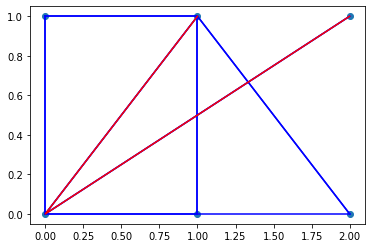

In [37]:

"""
1.A*算法是一种启发式搜索算法，它在 Dijkstra 算法的基础上添加了一个启发函数，用于加速搜索过程。

2.A*算法有两个重要的概念：代价函数（cost function）和启发函数（heuristic function）。代价函数 f(n) 用于表示从起点到当前点的真实距离，而启发函数 h(n) 用于表示从当前点到终点的预估距离。

3.openSet 和 closedSet 分别表示待搜索点和已搜索点，在循环中，我们首先取出 openSet 中 fScore 最小的点作为当前点，如果当前点为目标点，则返回结果。

4.cameFrom 用于记录每个点的前驱结点，gScore 记录的是从起点到当前点的真实距离，fScore 则是 gScore 与 h(n) 的和，用于表示从起点到当前点的预估距离。

5.代码中使用了一个计算预估距离的函数 heuristic_cost_estimate(a, b) 和重建路径的函数 reconstruct_path(cameFrom, current) 。预估距离的计算可以使用各种不同的方法，这里使用的是曼哈顿距离，而重建路径则是通过 cameFrom 中记录的前驱结点来进行反向遍历。

这只是一个简单的 A* 算法的示例代码，实际应用中需要根据问题的具体情况来进行调整。

提醒一点，A*算法需要使用优先队列来优化搜索速度，所以在python中使用heapq库来实现优先队列。

"""
import heapq

def astar(graph, start, goal):
    # 初始化数据
    closedSet = set()
    openSet = []
    heapq.heappush(openSet, (0, start))
    cameFrom = {}
    gScore = {start: 0}
    fScore = {start: heuristic_cost_estimate(start, goal)}

    while openSet:
        # 取出 openSet 中 fScore 最小的点
        current = heapq.heappop(openSet)[1]
        if current == goal:
            return reconstruct_path(cameFrom, goal)
        closedSet.add(current)

        # 更新点之间的距离
        for neighbor in graph[current]:
            if neighbor in closedSet:
                continue
            tentative_gScore = gScore[current] + graph[current][neighbor]

            if neighbor not in [i[1] for i in openSet]:
                heapq.heappush(openSet, (tentative_gScore, neighbor))
            elif tentative_gScore >= gScore[neighbor]:
                continue

            cameFrom[neighbor] = current
            gScore[neighbor] = tentative_gScore
            fScore[neighbor] = gScore[neighbor] + heuristic_cost_estimate(neighbor, goal)

    return None

def heuristic_cost_estimate(a, b):
    # 预估距离计算函数，只允许朝上下左右四个方向移动，使用曼哈顿距离（本例所用），若可以任意方向移动则使用欧式距离（车辆问题可用），八个方向用对角距离
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def reconstruct_path(cameFrom, current):
    # 通过 cameFrom 记录的前驱结点重建路径
    total_path = [current]
    while current in cameFrom:
        current = cameFrom[current]
        total_path.append(current)
    return list(reversed(total_path))


# 可视化
import matplotlib.pyplot as plt 

# test
graph = {(0,0):{(1,0):1,(0,1):1,(1,1):2**0.5,(2,1):5**0.5},
         (0,1):{(0,0):1,(1,1):1}, 
         (1,0):{(1,1):1,(0,0):1,(2,0):1},
         (1,1):{(1,0):1,(0,1):1,(0,0):2**0.5,(2,0):2**0.5},
         (2,0):{(1,1):2**0.5},
         (2,1):{(0,0):5**0.5},}
start = (1,1) # 起点
goal = (2,1) #终点
min_path = astar(graph, start, goal)

def show_min_dis(graph,min_path):
    
    # 顶点，边
    node,pair = [],[]
    for k,v in graph.items():
        node.append(k)
        for p in v.keys():
            pair.append((k,p))
    # 画点
    plt.plot(list(zip(*node))[0],list(zip(*node))[1],'o')
    
    # 画边
    tmp = []
    for x in pair:
        tmp.append(list(zip(*x)))
    for x in tmp:
        plt.plot(*x,'b')
    
    # 画最短路径
    plt.plot(*list(zip(*min_path)),'r')
    
    plt.show()
    
show_min_dis(graph,min_path)

#### 测试区

In [ ]:
data = {}
data['point'] = [[worker_lon,worker_lat]]

for s in route_stations:
    data['point'].append([ s["lon"], s["lat"]])

distances = []
for sp in data['point']:
    row_list = [0]
    for ep in data['point'][1:]:
        row_list.append(  int(haversine_dis(sp[0], sp[1],ep[0], ep[1] )))
    distances.append(row_list)
distances
        